# Exploratory Data Analysis and Feature Group

In [20]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os
import hopsworks
import joblib

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196773
Connected. Call `.close()` to terminate connection gracefully.


In [17]:
heart_df = pd.read_csv('dataset/heart.csv')

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
heart_df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [6]:
target = heart_df['HeartDisease']


In [7]:
heart_df.columns


Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [8]:
categorical = heart_df.select_dtypes(['object']).columns
categorical

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [23]:
# print all columns that are not categorical
numerical = heart_df.columns.difference(categorical)
numerical

Index(['BMI', 'MentalHealth', 'PhysicalHealth', 'SleepTime'], dtype='object')

# Preprocessing

In [9]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
heart_df[categorical] = ordinal_encoder.fit_transform(heart_df[categorical])

In [10]:
x = heart_df.drop('HeartDisease', axis=1)
y = heart_df['HeartDisease']

In [13]:
# TODO: Might need to move this to train.
joblib.dump(ordinal_encoder, 'heart_model/ordinal_encoder.pkl')


['heart_model/ordinal_encoder.pkl']

# Handle Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(x, y)

In [ ]:
heart_df_res = pd.concat([x_res, y_res], axis=1)

<AxesSubplot: xlabel='HeartDisease', ylabel='count'>

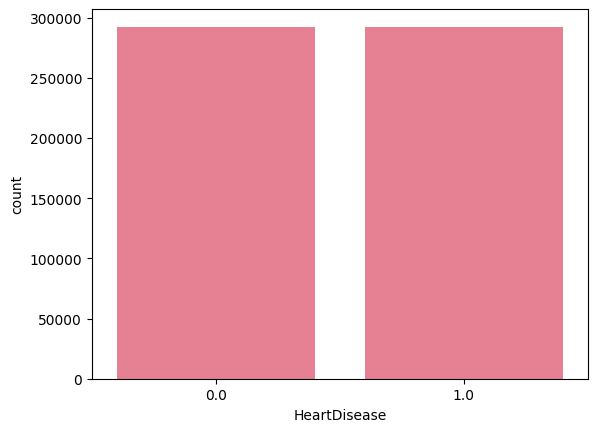

In [ ]:
sns.countplot(x='HeartDisease', data=heart_df_res)


# Exploration

<AxesSubplot: >

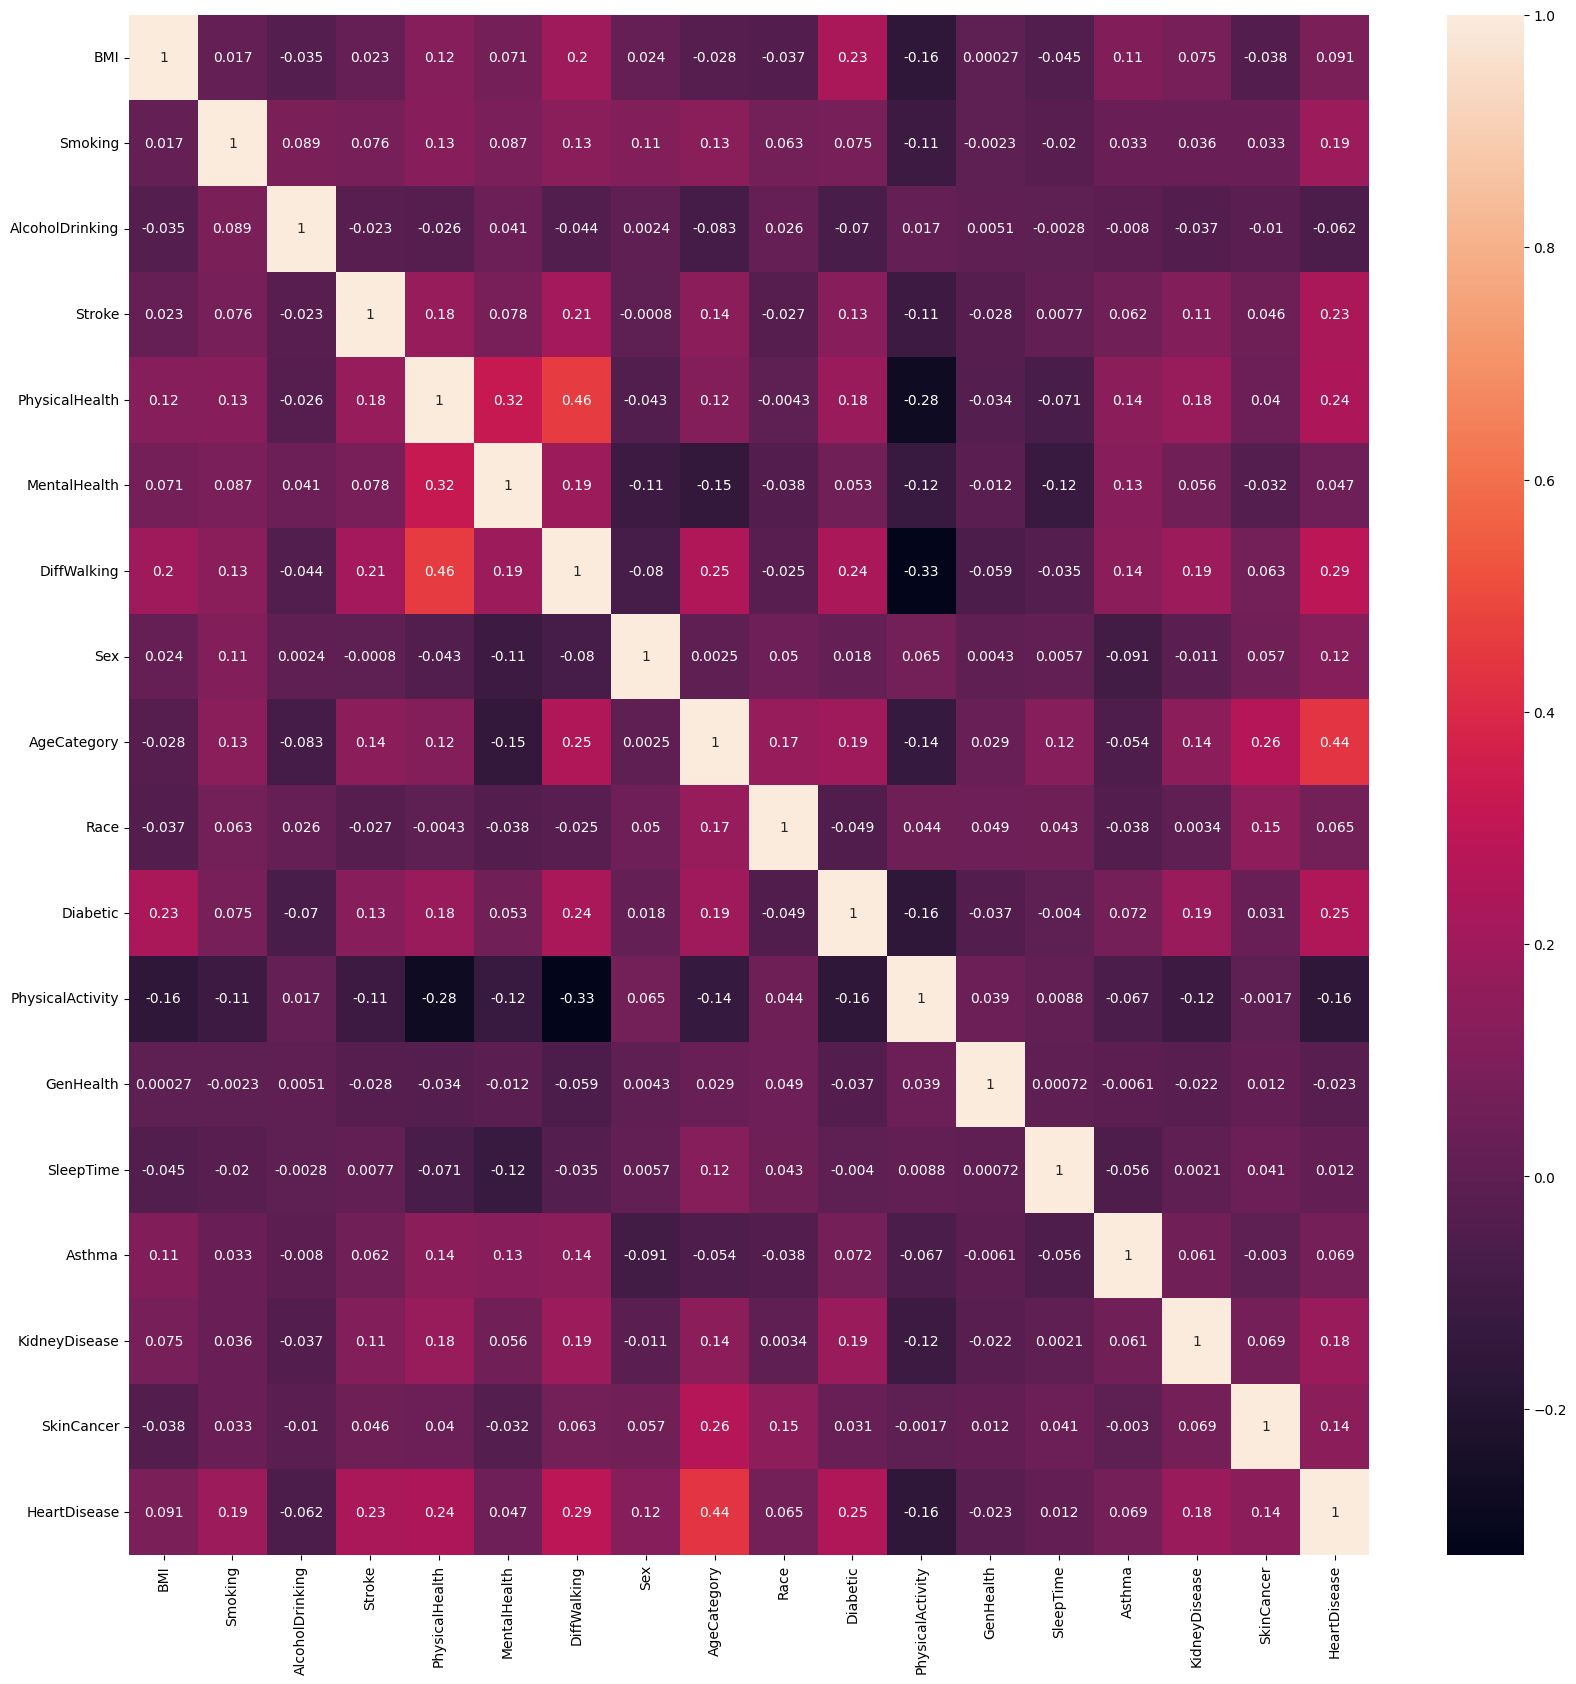

In [ ]:
corr = heart_df_res.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)

In [ ]:
corr = corr.abs().unstack()
corr = corr.sort_values(ascending=False)
corr = corr[corr >= 0.1]
print(corr["HeartDisease"])

HeartDisease        1.000000
AgeCategory         0.440228
DiffWalking         0.290264
Diabetic            0.253332
PhysicalHealth      0.242718
Stroke              0.230802
Smoking             0.189558
KidneyDisease       0.183134
PhysicalActivity    0.164264
SkinCancer          0.142076
Sex                 0.124205
dtype: float64


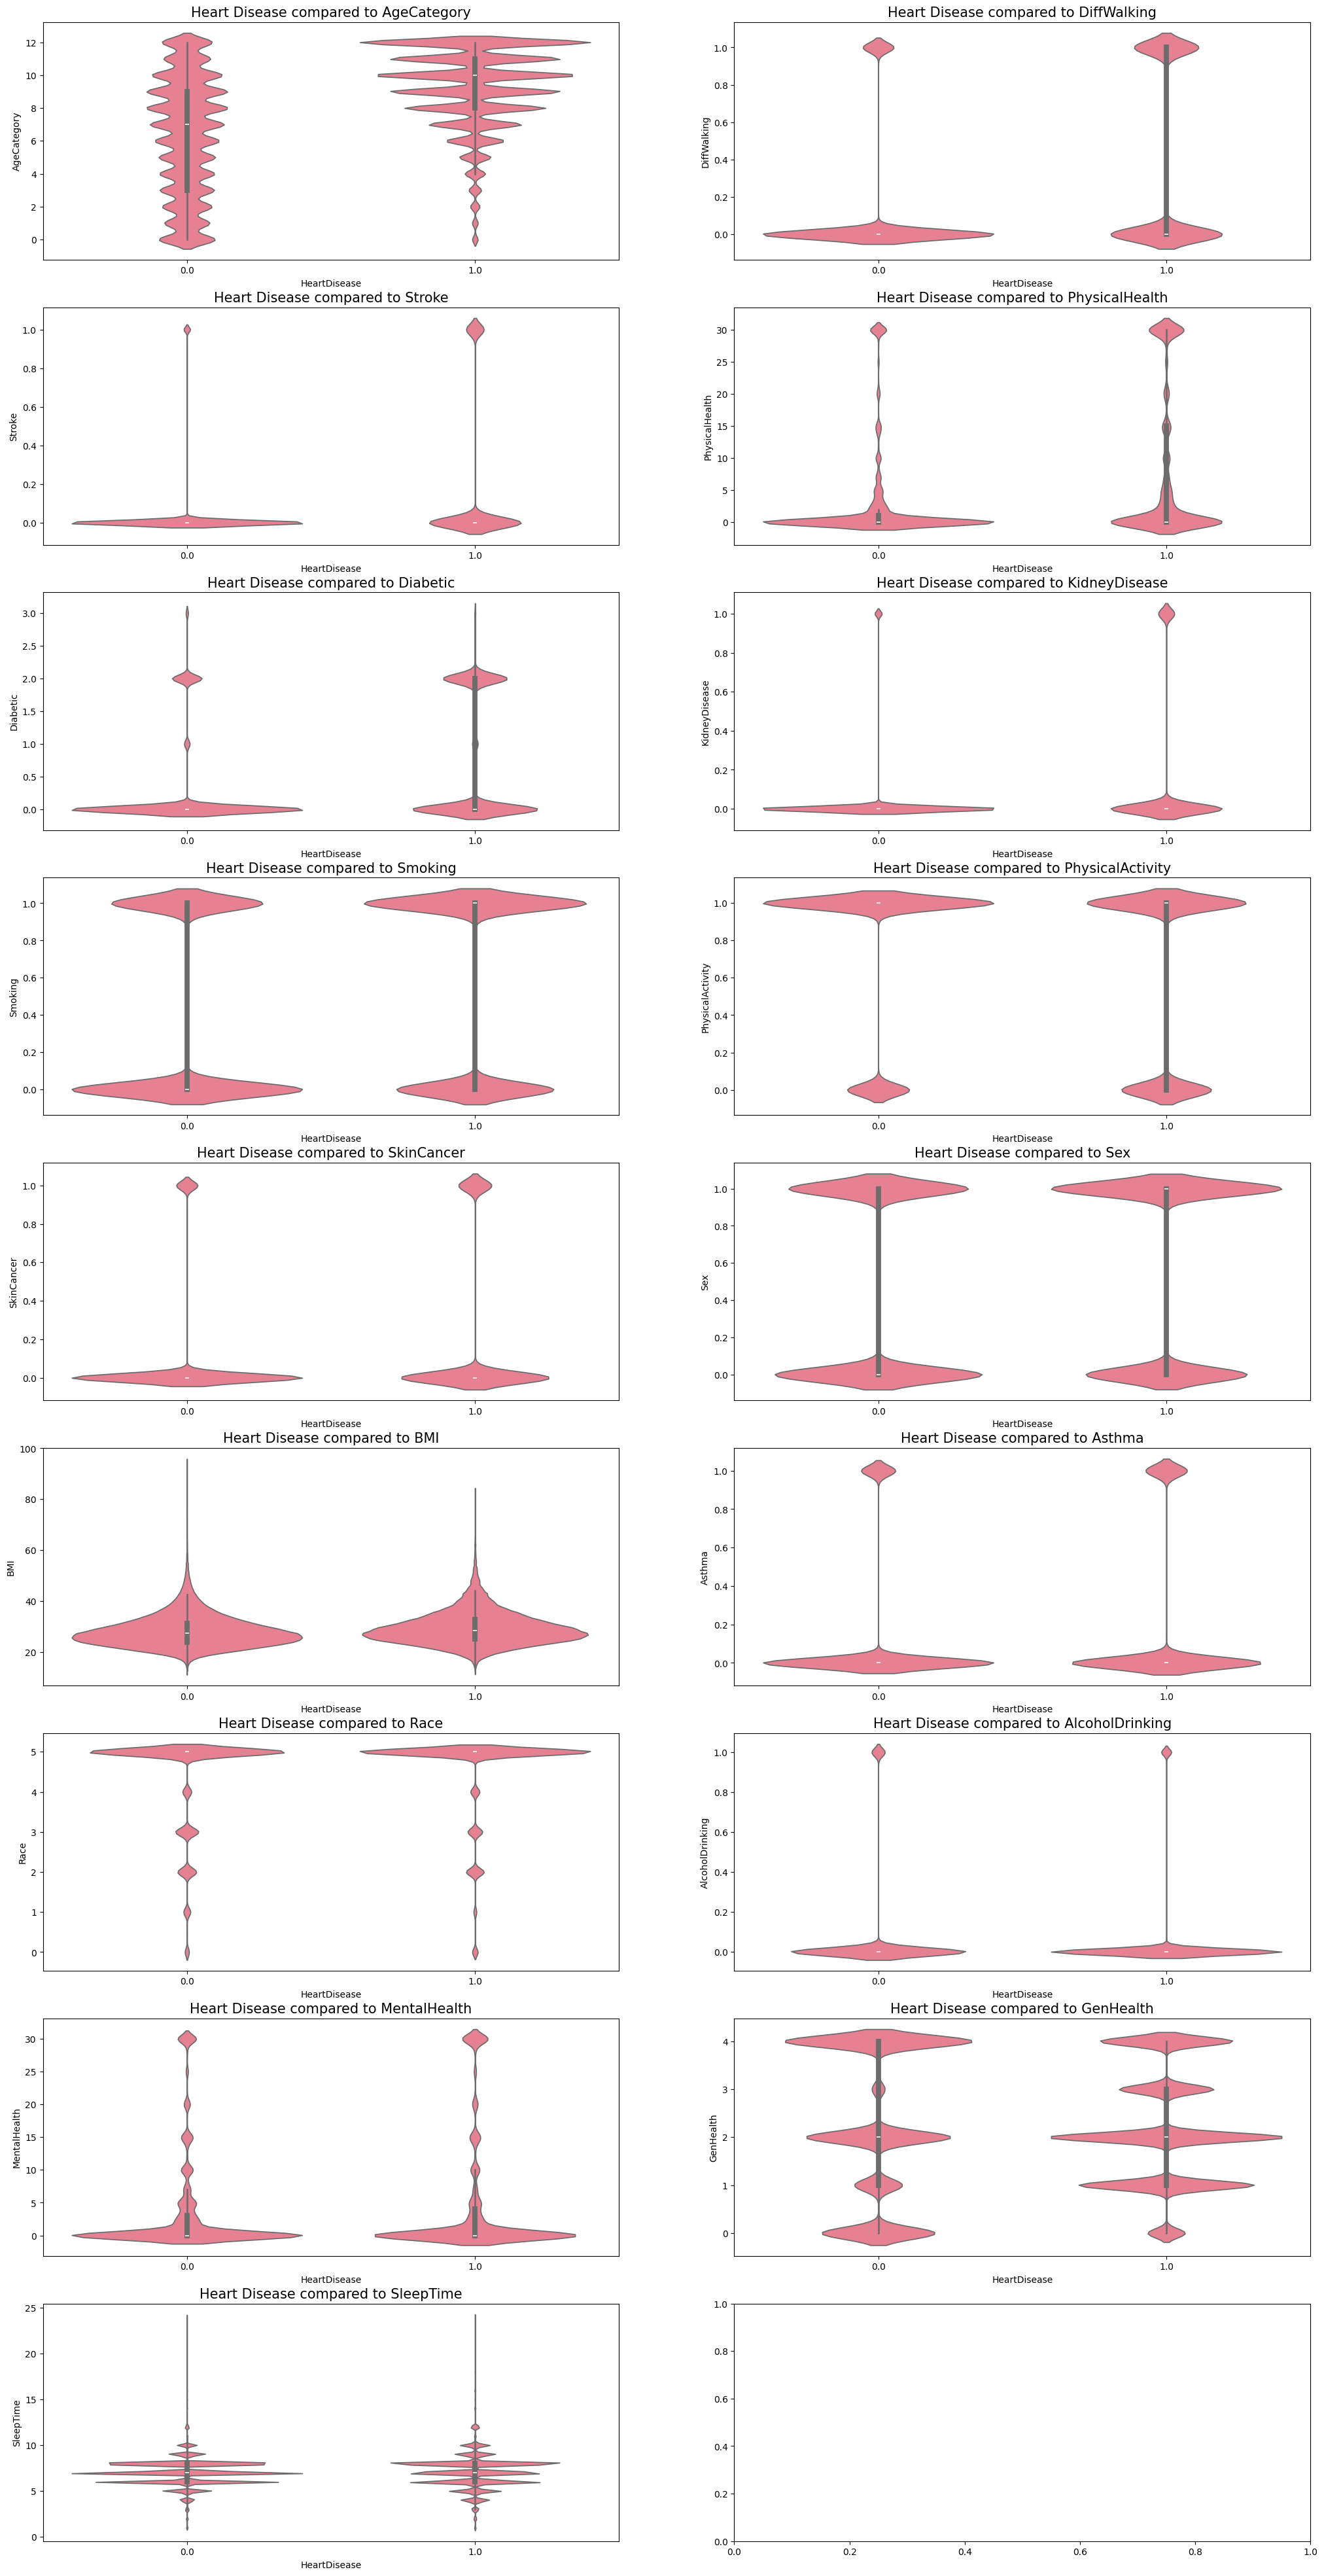

In [ ]:
important_features = ["AgeCategory", "DiffWalking", "Stroke", "PhysicalHealth", "Diabetic", "KidneyDisease", "Smoking", "PhysicalActivity", "SkinCancer", "Sex", "BMI", "Asthma", "Race", "AlcoholDrinking", "MentalHealth", "GenHealth", "SleepTime"]

num_cols = 2
num_rows = int((len(important_features) + 1) / num_cols)

axs, fig = plt.subplots(num_rows, num_cols, figsize=(25, 50))

for i, feature in enumerate(important_features):
    sns.violinplot(x="HeartDisease", y=feature, data=heart_df_res, ax=fig[i // num_cols, i % num_cols])
    fig[i // num_cols, i % num_cols].set_title(f"Heart Disease compared to {feature}", fontsize=15)

# Feature Store

In [ ]:
# add timestamp to each row
from datetime import datetime

heart_df_res['timestamp'] = datetime.now()

# * Important Hacky fix so that Hopsworks doesn't delete data :-)
heart_df_res['timestamp'] = heart_df_res['timestamp'] - pd.to_timedelta(heart_df_res.index, unit='s')

# change all column names to lowercase
heart_df_res.columns = map(str.lower, heart_df_res.columns)

In [ ]:
heart_fg = fs.get_or_create_feature_group(
    name="heart",
    version=1,
    primary_key=heart_df_res.columns,
    description="Heart Dataset",
    event_time="timestamp",
)
heart_fg.insert(heart_df_res, overwrite=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/196773/fs/196692/fg/330081


Uploading Dataframe: 0.00% |          | Rows 0/584844 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: heart_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/196773/jobs/named/heart_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f804b349340>, None)

# Sythentic Generator

In [ ]:
heart_df_res = heart_df_res.drop('timestamp', axis=1)


In [ ]:
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.regular import RegularSynthesizer

batch_size = 250
epochs = 20
learning_rate = 5e-6
beta_1 = 0.9
beta_2 = 0.9
models_dir="./cache/"

ctgan_args = ModelParameters(batch_size=batch_size,
                             lr=learning_rate,
                             betas=(beta_1, beta_2))

train_args = TrainParameters(epochs=epochs)

synth = RegularSynthesizer(modelname='ctgan', model_parameters=ctgan_args)

categorical_cols = ["HeartDisease"]
num_cols = [col for col in heart_df_res.columns if col not in  categorical_cols]

synth.fit(data = heart_df_res, train_arguments=train_args, cat_cols=categorical_cols, num_cols=num_cols)

os.makedirs(models_dir, exist_ok=True)
synth.save(models_dir + "generator.pkl")

# Model Registry

In [ ]:
import os
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="heart_generator"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
synth.save(model_dir + '/heart_generator.pkl')

# Create a schema for the model
input_schema = Schema(heart_df_res)
output_schema = Schema(heart_df_res)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
heart_generator = mr.python.create_model(
    name="heart_generator", 
    model_schema=model_schema,
    description="heart Generator Model",
)

heart_generator.save(models_dir)